# 🎲 Transpilation Overview

**Quantum Transpilation** is the transformation of a given virtual quantum circuit:

- to match the topology of a specific device
- to optimize the circuit for execution

Rivet Transpiler package provides a family of functions for efficient transpilation of quantum circuits.

### Transpilation Stages

1) **Init** - Unrolling custom instructions and converting the circuit to all 1 and 2 qubit gates.

2) **Layout** - Mapping circuit virtual qubits to backend physical qubits.

3) **Routing** - Inject SWAP gates to comply with the backend’s coupling map.

4) **Translation** - Translate to the target backend’s basis gate set.

5) **Optimization** - Main optimization loop to increase circuit quality.

6) **Scheduling** - Conversion to hardware-specific pulses.

In [1]:
# https://qiskit.org/documentation/apidoc/transpiler.html

### Transpile Functions

`transpile` - custom transpilation with possibility of using:

- different transpilation stacks
- custom PassManager
- dynamical decoupling
- transpiler options

`transpile_chain` - consistently transpile and "stitch" a chain of quantum circuits.

`transpile_right` - transpile an additional circuit to the right part of the existing circuit.

`transpile_left` - transpile an additional circuit to the left part of the existing circuit.

`transpile_and_compress` - transpile and "topologically compress" a circuit considering a coupling map of the selected backend.

# 🎱 Transpilation Examples

In [2]:
import qiskit

from qiskit.providers.aer import AerSimulator

from qiskit.providers.fake_provider import FakeBackend5QV2
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeMontrealV2
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.providers.fake_provider import FakeBoeblingenV2

In [3]:
import numpy as np

from tqdm import tqdm

from matplotlib import pyplot as plt

plt.style.use("dark_background")

In [ ]:
# Rivet Transpiler Imports

%cd ..

# Transpile Functions

from rivet_transpiler import transpile
from rivet_transpiler import transpile_chain
from rivet_transpiler import transpile_right
from rivet_transpiler import transpile_left
from rivet_transpiler import transpile_and_compress
from rivet_transpiler import transpile_and_return_metrics

# Service Functions

from rivet_transpiler import get_full_map
from rivet_transpiler import get_ibm_cost
from rivet_transpiler import get_circuit_hash

from rivet_transpiler import get_cnot_circuit
from rivet_transpiler import get_litmus_circuit

### Litmus Circuit

**Litmus circuit** is a minimal quantum circuit which consists of:

- Parametrized RZ gate on each qubit (each parameter name matches the  index of the virtual qubit - to trace consequent permutations of qubits during layout and routing phases of transpilation).

- Circular CNOT gates (necessary to introduce SWAPs during transpilation to not fully connected topology).

In [5]:
QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

litmus_circuit.draw()

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

### Backend

**Fake backend** is an Aer simulator with properties of a real backend:

- coupling map
- basis gates
- noise model

Fake backends are useful for testing the transpiler and performing noisy simulations of the system.

For minimal example we select 5-qubit fake backend with linear topology.

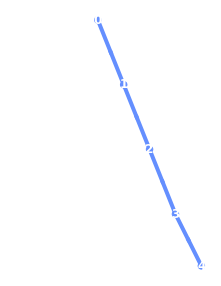

In [6]:
FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
# FAKE_BACKEND = FakeMontrealV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Qiskit Transpile

In [7]:
transpiled_circuit = qiskit.transpile(
    litmus_circuit, 
    backend,
    seed_transpiler=1234,
    initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_circuit.draw()

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                ┌─────────────────┐               ┌───┐           ░ 
Litmus_0_0 -> 0 ┤ U(0,0,Litmus_0) ├──■─────────■──┤ X ├──■────────░─
                ├─────────────────┤┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐ ░ 
Litmus_0_1 -> 1 ┤ U(0,0,Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─
                ├─────────────────┤└───┘┌─┴─┐└───┘     └───┘└─┬─┘ ░ 
Litmus_0_2 -> 2 ┤ U(0,0,Litmus_2) ├─────┤ X ├─────────────────■───░─
                └─────────────────┘     └───┘                     ░ 
 ancilla_0 -> 3 ──────────────────────────────────────────────────░─
                                                                  ░ 
 ancilla_1 -> 4 ──────────────────────────────────────────────────░─
                                                                  ░

### Pass Manager

**Pass Manager** is an internal Qiskit object constructed by the `transpile` function "under the hood" during transpilation.

Pass Manager consists of Passes which analyse or change the transpiled circuit.

Calling `pass_manager.run` is equivalent to calling `transpile` and passing a circuit, backend and corresponding transpilation parameters.

In [8]:
# https://docs.quantum.ibm.com/api/qiskit/passmanager

In [9]:
pass_manager = qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager(
    
    optimization_level=3,
    backend=backend,
    # initial_layout=[1, 0, 2],
    seed_transpiler=1234
)

In [10]:
pass_manager.stages

('init', 'layout', 'routing', 'translation', 'optimization', 'scheduling')

In [11]:
# pass_manager.draw()

In [12]:
# pass_manager.init.draw()

In [13]:
# pass_manager.routing.draw()

In [14]:
# pass_manager.optimization.draw()

In [15]:
# pass_manager.layout.passes()

In [16]:
transpiled_litmus_circuit = pass_manager.run(litmus_circuit)

transpiled_litmus_circuit.draw(fold=-1)

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

## Circuit Stitching

**Task:** to "stitch" together transpiled circuits into a chain.

Disconnected qubits are routed closer using SWAPs gates – **but not routed back** to avoid additional SWAPs – therefore allocation of virtual qubit changes.

We need to know the final allocation of qubits after transpilation.

Unfortunately, Qiskit does not provide such allocation.

Instead - Qiskit transpiled circuit contains ‘layout’ property with data on applied qubit permutations:

- ‘initial_layout’ – initial placement of incoming virtual qubits during Layout stage.

- ‘final_layout’ – placement of outgoing virtual qubits during Routing stage.

Function `get_full_map` follows above permutations to return final allocation of qubits after transpilation.

In [17]:
get_full_map(transpiled_litmus_circuit)

[1, 3, 2, 0, 4]

To find final allocation of qubits after transpilation we work with 3 sets of qubits:

- Incoming virtual qubits of the initial circuit
- Outgoing virtual qubits of the transpiled circuit
- Physical qubits of the selected backend

Example of qubit allocation during transpilation:

- `Zero Map` - Ancillas added
- `After Layout` - Initial layout applied 
- `After Routing` - SWAPs applied 
- `Full Map` - Final qubit allocation 

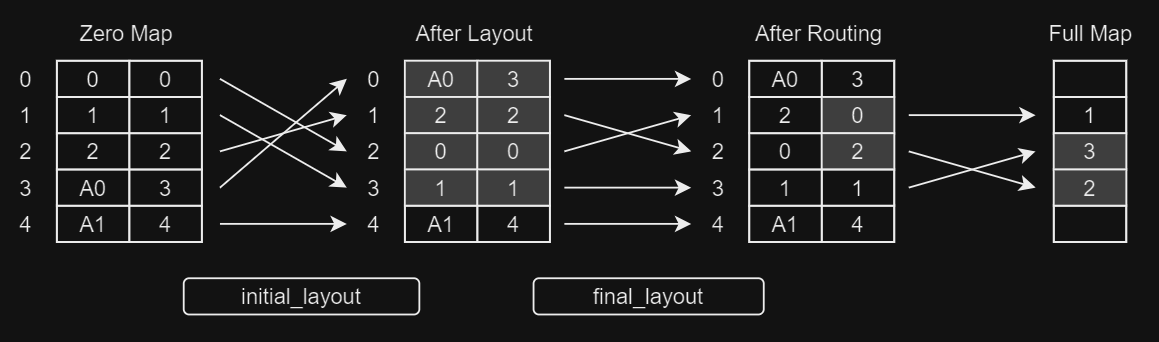

In [18]:
transpiled_litmus_circuit.draw()

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

### Our Transpile

Interface of `transpile` function matches `qiskit.transpile` - but allows additional parameters like:

- pre-defined transpilation stacks
- custom PassManager
- dynamical decoupling
- transpiler options

In [19]:
transpiled_circuit = transpile(
    litmus_circuit, 
    backend,
    seed_transpiler=1234,
    # initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_circuit.draw()

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

Final qubit allocation after transpilation:

In [20]:
get_full_map(transpiled_circuit)

[1, 3, 2, 0, 4]

### Transpile Chain

Consistently transpile and "stitch" a chain of quantum circuits.

In [21]:
CHAIN = [litmus_circuit] * 5

transpiled_chain_circuit = transpile_chain(
    CHAIN, 
    backend,
    seed_transpiler=1234,
    initial_layout=[0, 1, 2]
    # initial_layout=[0, 2, 4]
)

transpiled_chain_circuit.draw(fold=-1)

global phase: -2.5*Litmus_0 - 2.5*Litmus_1 - 2.5*Litmus_2
                ┌─────────────────┐               ┌───┐           ░ ┌─────────────────┐┌───┐                          ░ ┌─────────────────┐     ┌───┐          ┌───┐     ┌───┐           ░ ┌─────────────────┐     ┌───┐          ┌───┐     ┌───┐           ░ ┌─────────────────┐     ┌───┐          ┌───┐     ┌───┐           ░ 
Litmus_0_1 -> 0 ┤ U(0,0,Litmus_0) ├──■─────────■──┤ X ├──■────────░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■────────░─┤ U(0,0,Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■────────░─┤ U(0,0,Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■────────░─
                ├─────────────────┤┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐ ░ ├─────────────────┤└─┬─┘┌───┐     ┌───┐┌─┴─┐      ░ ├─────────────────┤┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐      ░ ├─────────────────┤┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐      ░ ├─────────────────┤┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐      ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■───░─┤ U(0,0,Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■───░─┤ U(0,0,Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■───░─
                ├─────────────────┤└───┘┌─┴─┐└───┘     └───┘└─┬─┘ ░ ├─────────────────┤     └─┬─┘┌─┴─┐└─┬─┘└───┘┌─┴─┐ ░ ├─────────────────┤└───┘     └───┘└─┬─┘     └───┘     └───┘┌─┴─┐ ░ ├─────────────────┤└───┘     └───┘└─┬─┘     └───┘     └───┘┌─┴─┐ ░ ├─────────────────┤└───┘     └───┘└─┬─┘     └───┘     └───┘┌─┴─┐ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_2) ├─────┤ X ├─────────────────■───░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,Litmus_0) ├─────────────────■──────────────────────┤ X ├─░─┤ U(0,0,Litmus_0) ├─────────────────■──────────────────────┤ X ├─░─┤ U(0,0,Litmus_0) ├─────────────────■──────────────────────┤ X ├─░─
                └─────────────────┘     └───┘                     ░ └─────────────────┘          └───┘          └───┘ ░ └─────────────────┘                                        └───┘ ░ └─────────────────┘                                        └───┘ ░ └─────────────────┘                                        └───┘ ░ 
 ancilla_0 -> 3 ──────────────────────────────────────────────────░───────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░─
                                                                  ░                                                   ░                                                                  ░                                                                  ░                                                                  ░ 
 ancilla_1 -> 4 ──────────────────────────────────────────────────░───────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────░─
                                                                  ░                                                   ░                                                                  ░                                                                  ░                                                                  ░

In [22]:
get_full_map(transpiled_chain_circuit)

[2, 0, 1, 3, 4]

### Transpile Right

Transpile additional circuit to the right part of existing circuit.

In [23]:
transpiled_circuit.draw()

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

In [24]:
cnot_circuit = get_cnot_circuit(QUBITS_COUNT, "CNOT", [0, 1])

cnot_circuit.draw()

┌────────────┐      CNOT 
CNOT_0_0: ┤ Rz(CNOT_0) ├──■────░───
          ├────────────┤┌─┴─┐  ░   
CNOT_0_1: ┤ Rz(CNOT_1) ├┤ X ├──░───
          ├────────────┤└───┘  ░   
CNOT_0_2: ┤ Rz(CNOT_2) ├───────░───
          └────────────┘       ░

In [25]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_right_circuit.draw(fold=-1)

global phase: -0.5*CNOT_0 - 0.5*CNOT_1 - 0.5*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                          ░ 
 ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────░─
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ ┌───────────────┐                     ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,CNOT_0) ├─────────────────■───░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ ├───────────────┤┌───┐     ┌───┐┌─┴─┐ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├─░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ ├───────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘ ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,CNOT_1) ├──■──┤ X ├──■────────░─
                └─────────────────┘└───┘                          ░ └───────────────┘     └───┘           ░ 
 ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────░─
                                                                                                          ░

In [26]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_right_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234,
)

transpiled_right_circuit.draw(fold=-1)

global phase: -1.0*CNOT_0 - 1.0*CNOT_1 - 1.0*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                          ░                             
 ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ ┌───────────────┐                     ░ ┌───────────────┐      CNOT 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,CNOT_0) ├─────────────────■───░─┤ U(0,0,CNOT_0) ├──■────░───
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ ├───────────────┤┌───┐     ┌───┐┌─┴─┐ ░ ├───────────────┤┌─┴─┐  ░   
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├─░─┤ U(0,0,CNOT_1) ├┤ X ├──░───
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ ├───────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘ ░ ├───────────────┤└───┘  ░   
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,CNOT_1) ├──■──┤ X ├──■────────░─┤ U(0,0,CNOT_2) ├───────░───
                └─────────────────┘└───┘                          ░ └───────────────┘     └───┘           ░ └───────────────┘       ░   
 ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────
                                                                                                          ░

### Transpile Left

Transpile additional circuit to the left part of existing circuit.

In [27]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_circuit,
    left_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

global phase: -0.5*CNOT_0 - 0.5*CNOT_1 - 0.5*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                
ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────
               ┌───────────────────┐      ░ ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
 CNOT_0_2 -> 1 ┤ U(0,1.0*CNOT_2,0) ├──────░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
               ├───────────────────┤      ░ ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
 CNOT_0_0 -> 2 ┤ U(0,1.0*CNOT_0,0) ├──■───░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
               ├───────────────────┤┌─┴─┐ ░ ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
 CNOT_0_1 -> 3 ┤ U(0,1.0*CNOT_1,0) ├┤ X ├─░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
               └───────────────────┘└───┘ ░ └─────────────────┘└───┘                          ░ 
ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────

In [28]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_left_circuit,
    left_circuit=litmus_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

global phase: -0.5*CNOT_0 - 0.5*CNOT_1 - 0.5*CNOT_2 - 1.0*Litmus_0 - 1.0*Litmus_1 - 1.0*Litmus_2
                                                                                                                                                         
 ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                ┌─────────────────────┐     ┌───┐                     ░ ┌───────────────────┐      ░ ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,1.0*Litmus_2,0) ├─────┤ X ├─────────────────■───░─┤ U(0,1.0*CNOT_2,0) ├──────░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────────┤┌───┐└─┬─┘┌───┐     ┌───┐┌─┴─┐ ░ ├───────────────────┤      ░ ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_1 -> 2 ┤ U(0,1.0*Litmus_1,0) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─┤ U(0,1.0*CNOT_0,0) ├──■───░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────────┤└─┬─┘     └─┬─┘┌─┴─┐└─┬─┘└───┘ ░ ├───────────────────┤┌─┴─┐ ░ ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_0 -> 3 ┤ U(0,1.0*Litmus_0,0) ├──■─────────■──┤ X ├──■────────░─┤ U(0,1.0*CNOT_1,0) ├┤ X ├─░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────────┘               └───┘           ░ └───────────────────┘└───┘ ░ └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Transpile and Compress

`transpile_and_compress` allows to "topologically compress" a circuit - considering a coupling map of selected backend - to avoid using unnecessary ancilla qubits.

For demonstration - we take fake backend with more complicated topology:

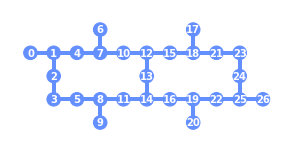

In [29]:
FAKE_BACKEND = FakeMontrealV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

In [30]:
transpiled_litmus_circuit = transpile(
    litmus_circuit, 
    backend,
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234
)

transpiled_litmus_circuit.draw(idle_wires=False)

┌───┐                          ░ 
 ancilla_13 -> 5 ───────■────────┤ X ├──■───────────────────────░─
                      ┌─┴─┐      └─┬─┘┌─┴─┐                     ░ 
 ancilla_14 -> 8 ─────┤ X ├────────■──┤ X ├─────────────────────░─
                 ┌────┴───┴─────┐┌───┐└───┘                     ░ 
Litmus_0_1 -> 11 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░─
                 ├──────────────┤└─┬─┘┌───┐     ┌───┐  │  ┌───┐ ░ 
Litmus_0_2 -> 13 ┤ Rz(Litmus_2) ├──┼──┤ X ├──■──┤ X ├──┼──┤ X ├─░─
                 ├──────────────┤  │  └─┬─┘┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘ ░ 
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■────■──┤ X ├──■──┤ X ├──■───░─
                 └──────────────┘          └───┘     └───┘      ░

In [31]:
compressed_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=backend,
    # stack='qiskit',
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234,
)

compressed_circuit.draw(idle_wires=False)

┌──────────────┐          ┌───┐          ┌───┐ ░  ░ 
Litmus_0_2 -> 12 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░──░─
                 ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░  ░ 
Litmus_0_0 -> 13 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░────
                 ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░  ░ 
Litmus_0_1 -> 14 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░──░─
                 └──────────────┘└───┘                          ░  ░

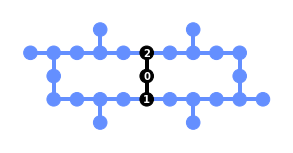

In [32]:
qiskit.visualization.plot_circuit_layout(compressed_circuit, FAKE_BACKEND)

`transpile_and_compress` selects topologically most important qubits of a backend
to produce limited coupling map - to decrease transpilation and simulation time:

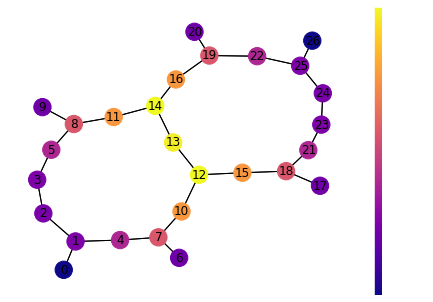

We use flexible measure of a node importance - node “closeness centrality” in the backend topology graph.

Closeness centrality is efficiently calculated using the “rustworkx” graph library function: https://qiskit.org/ecosystem/rustworkx/dev/apiref/rustworkx.closeness_centrality.html

Flexible measure of node importance can be expanded with other metrics. 
For example, neighbors counts or qubit noise levels.

Once importances are calculated - we traverse topology graph using A-star search -
starting from the most important node.

Traversed nodes are added to limited qubit list which forms a connected subgraph.

Discovered subgraph is used to limit the backend topology during transpilation.

### Transpile and Return Metrics

`transpile_and_return_metrics` function transpiles circuit with given parameters and returns transpilation metrics.

In [33]:
transpiled_circuit, metrics = transpile_and_return_metrics(
    litmus_circuit, 
    backend=backend,
    optimization_level=3,
    seed_transpiler=1234
)

In [34]:
transpiled_circuit.draw(fold=-1, idle_wires=False)

┌──────────────┐┌───┐                          ░ 
Litmus_0_1 -> 11 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░─
                 ├──────────────┤└─┬─┘     ┌───┐       │  ┌───┐ ░ 
Litmus_0_2 -> 13 ┤ Rz(Litmus_2) ├──┼────■──┤ X ├──■────┼──┤ X ├─░─
                 ├──────────────┤  │  ┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘ ░ 
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                 └──────────────┘     └───┘     └───┘└───┘      ░

In [35]:
metrics[0]

{'pass_index': 0,
 'pass_name': 'ContainsInstruction',
 'pass_type': 'Analysis',
 'time': 1.0013580322265625e-05,
 'depth': 5,
 'width': 3,
 'ibm_cost': 0.9498972910479807,
 'gates_counter': {1: 3, 2: 3}}

### Transpilation Stacks

Four pre-defined transpilation stacks have been added:

- Qiskit transpilation
- Pytket transpilation
- BQSKit QSearch synthesis
- BQSKit QFactor instantiation

#### Synthesis

**Quantum circuit synthesis** is the process of converting a mathematical description of a quantum transformation - often given as a unitary matrix - into a circuit composed of gates from a fixed gate set.

**Search-based** class of synthesis tools is categorized by the discrete search for a desired circuit through a space of circuits. These techniques are usually bottom-up, they start with an empty circuit and grow out as they search through the space.

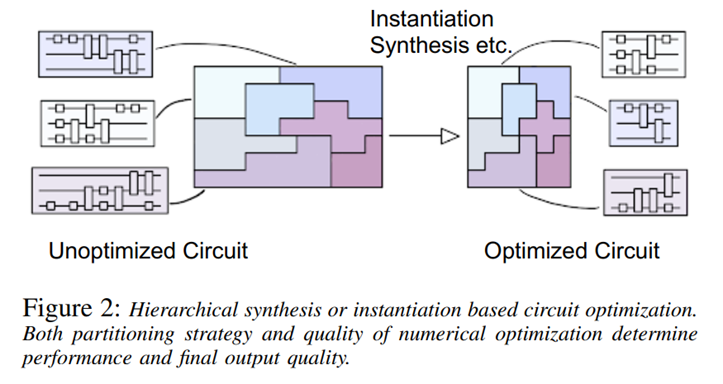

[1] QFactor: A Domain-Specific Optimizer for Quantum Circuit Instantiation – https://arxiv.org/pdf/2306.08152.pdf

#### QSearch

**QSearch** is a powerful search-based synthesis tool, which phrases the problem of circuit synthesis as a search over circuit structures combined with numerical optimization to instantiate circuit parameters.

1) The algorithm starts by placing single-qubit rotations on all qubits. 

2) The circuit is then instantiated by calling a numerical optimization subroutine to solve for the gate's parameters that minimize the distance between the circuit's unitary and the target unitary. 

3) After this, fixed building blocks composed of two-qubit gates followed by single-qubit rotations are placed on all pairs of qubits. 

This branching pattern forms the circuit tree, where at depth n in the tree, all possible circuit structures with n two-qudit gates exist. 

Each structure is a candidate solution is evaluated using the same numerical optimization process, and the order of evaluations is determined by A* search.

#### Stacks Usage

In [36]:
STACKS = ["qiskit",
          "qiskit_qsearch",
          "qiskit_qfactor_qsearch",
          "qiskit_pytket"]

For demonstration - we come back to 5-qubit fake backend with linear topology:

In [37]:
# Backend

FAKE_BACKEND = FakeBackend5QV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

#### Qiskit

In [38]:
transpiled_circuit = transpile(
    litmus_circuit,
    backend,
    stack="qiskit",
    seed_transpiler=1234)

transpiled_circuit.draw()    

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

#### Pytket

In [39]:
transpiled_circuit = transpile(
    litmus_circuit,
    backend,
    stack="qiskit_pytket",
    seed_transpiler=1234)

transpiled_circuit.draw()    

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

#### QSearch

In [40]:
# Bind Circuit Parameters

bound_litmus_circuit = litmus_circuit.copy()

for index, parameter in enumerate(litmus_circuit.parameters):
    
    bound_litmus_circuit.assign_parameters(
        {parameter: index}, 
        inplace=True)

In [41]:
transpiled_circuit = transpile(
    bound_litmus_circuit,
    backend,
    stack="qiskit_qsearch",
    qsearch_block_size=2,
    seed_transpiler=1234)

transpiled_circuit.draw(fold=-1)    

global phase: 5.6722
                                          ┌─────────────────────────┐                                  
      q_0 -> 0 ────────────────────────■──┤ U(3.1413,3.1104,6.2524) ├──────────────────────────────────
               ┌────────────────────┐┌─┴─┐└─┬─────────────────────┬─┘                                  
      q_1 -> 1 ┤ U(π,4.7902,2.6486) ├┤ X ├──┤ U(π,0.99302,4.1346) ├────■───────────────────────────────
               ├────────────────────┤└───┘  └─────────────────────┘  ┌─┴─┐┌───────────────────────────┐
      q_2 -> 2 ┤ U(π,5.5877,4.4461) ├────────────────────────────────┤ X ├┤ U(3.1415,-2.8041,-2.8351) ├
               └────────────────────┘                                └───┘└───────────────────────────┘
ancilla_0 -> 3 ────────────────────────────────────────────────────────────────────────────────────────
                                                                                                       
ancilla_1 -> 4 ────────────────────────────────────────────────────────────────────────────────────────

#### QFactor + QSearch

In [42]:
transpiled_circuit = transpile(
    bound_litmus_circuit,
    backend,
    stack="qiskit_qfactor_qsearch",
    qsearch_block_size=2,
    seed_transpiler=1234)

transpiled_circuit.draw(fold=-1)   

global phase: 2.924
                                               ┌────────────────────────────┐      ┌─────────────────────────────┐                                  
      q_0 -> 0 ───────────────■────────────────┤ U(3π/2,3.4926,-1.2683e-08) ├──■───┤ U(2.5701,0.0028304,-1.9199) ├──────────────────────────────────
                            ┌─┴─┐              └─┬───────────────────────┬──┘┌─┴─┐┌┴─────────────────────────────┴─┐                                
      q_1 -> 1 ─────────────┤ X ├────────────────┤ U(5π/2,3.1416,3.4008) ├───┤ X ├┤ U(1.5708,-0.25918,-1.0141e-08) ├──■─────────────────────────────
               ┌────────────┴───┴─────────────┐  └───────────────────────┘   └───┘└────────────────────────────────┘┌─┴─┐┌─────────────────────────┐
      q_2 -> 2 ┤ U(0.035961,0.69704,-0.26702) ├─────────────────────────────────────────────────────────────────────┤ X ├┤ U(6.3007,1.5708,4.7124) ├
               └──────────────────────────────┘                                                                     └───┘└─────────────────────────┘
ancilla_0 -> 3 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                    
ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Circuit Hash

Function `get_circuit_hash` calculates SHA256 hash for a given quantum circuit.

Hash is based on properties of circuit gates:

- Instruction class (RX, CNOT, CRZ, etc.)
- Parameter values (angles)
- Used qubits
- Used classical bits

Parameter names are ignored - circuits with not-bound RZ("theta_1") and RZ("theta_2") will have equal hashes.

Inspired by Qiskit `soft_compare` gate function:

https://github.com/Qiskit/qiskit/blob/main/qiskit/circuit/instruction.py#L227

In [43]:
get_circuit_hash(litmus_circuit)

91117950654430335247890747277320998917388595147286464376247203058138507516842

In [44]:
get_circuit_hash(transpiled_circuit)

63653558644872864659735494019466018773601732887527259272032495392391926847478

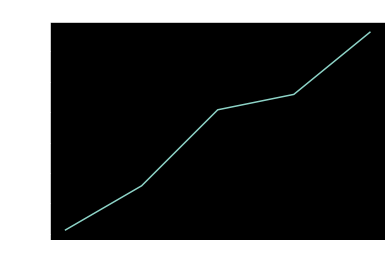

### IBM Cost

IBM Cost is a product of gate fidelities (F) and depth penalization (K):

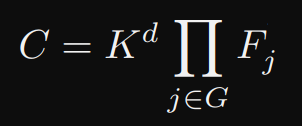

* K - circuit depth penalization factor
* d - circuit depth
* G - gates
* F - fidelities

IBM Cost can be used as circuit quality metric.

[1] “Demonstration of quantum volume 64 on a superconducting quantum computing system” – IBMQ – P. Jurcevic, A. Javadi-Abhari, L. S. Bishop and others – https://arxiv.org/abs/2008.08571

In [45]:
litmus_circuit.draw()

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

In [46]:
get_ibm_cost(litmus_circuit)

0.9498972910479807

In [47]:
transpiled_circuit.draw(fold=-1)

global phase: 2.924
                                               ┌────────────────────────────┐      ┌─────────────────────────────┐                                  
      q_0 -> 0 ───────────────■────────────────┤ U(3π/2,3.4926,-1.2683e-08) ├──■───┤ U(2.5701,0.0028304,-1.9199) ├──────────────────────────────────
                            ┌─┴─┐              └─┬───────────────────────┬──┘┌─┴─┐┌┴─────────────────────────────┴─┐                                
      q_1 -> 1 ─────────────┤ X ├────────────────┤ U(5π/2,3.1416,3.4008) ├───┤ X ├┤ U(1.5708,-0.25918,-1.0141e-08) ├──■─────────────────────────────
               ┌────────────┴───┴─────────────┐  └───────────────────────┘   └───┘└────────────────────────────────┘┌─┴─┐┌─────────────────────────┐
      q_2 -> 2 ┤ U(0.035961,0.69704,-0.26702) ├─────────────────────────────────────────────────────────────────────┤ X ├┤ U(6.3007,1.5708,4.7124) ├
               └──────────────────────────────┘                                                                     └───┘└─────────────────────────┘
ancilla_0 -> 3 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                    
ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [48]:
get_ibm_cost(transpiled_circuit)

0.939294010433498